# Behind the scenes of WENO Box

Now that the mathematical workings of the WENO method have been described, let's take a closer look at the scheme from an algorithmic perspective.  We will consider the case of a system of $m$ non-linear conservation laws, with a vector of primitive variables $u_{i}$, a vector of conservative variables $\bar{u}_i$, and a vector of flux functions $f(u_i)$.  For instance, for the case of the Euler Equations of Gas Dynamics, we have the following:

$$
\begin{align}
u_i&=[\rho,v,p]\\
\bar{u}_i&=[\rho,\rho v,\rho(e+\frac{1}{2}v^2)]\\
f_i(u)&=[\rho v,\rho v^2 + p,(\rho e+\frac{1}{2}\rho v^2 + p)v]
\end{align}
$$

subject to the general one-dimmensional conservation law:

$$
\frac{\partial u_i}{\partial t}+\frac{\partial}{\partial x}[f_i(u)]=0
$$

The WENO Box operates on the primitive variables $u_i$ to form a set of left-biased and right-biased weighted  polynomial reconstructions of the primitive variables _at the cell-boundaries_.  That is, given a set of primitive variables evaluated over a spatial domain $x_j$, we seek to find $u_i$ _evaluated_ at $x_j+\frac{1}{2}h$ where $h$ is the step size of the discretized domain. 

## Flow of Algorithm

The WENO algorithm follows the following process:

1. Given the set of conservative variable vectors, calculate the primitive variables

    $$\bar{u}_i \longrightarrow u_i$$
    
2. From the primitive variables, calculate the flux stabilization parameter $\alpha$ as defined by the Lax-Friedrichs method of flux splitting:
    
    $$ Au_i \longrightarrow \alpha$$
    

3. Take the primitive variables into characteristic space:
    $$
    w_i=Q_{q,i}^{-1}u_i
    $$
    
    (Note this step requires considerable care and is not as straightforward as perhaps indicated by the above equation)


4. 
    * Form the _left_ WENO reconstruction of the primitive variables in characteristic space
 
    $$
    w_i \longrightarrow w^{L,WENO}_{i+\frac{1}{2}}
    $$
    
    * Form the _right_ WENO reconstruction of the primitive variables in characteristic space

    $$
    w_i \longrightarrow w^{R,WENO}_{i+\frac{1}{2}}
    $$
    
5.  
    * Return the _left_ WENO reconstruction of the primitive variables from characteristic space
 
    $$
    u^{L,WENO}_{i+\frac{1}{2}} = Qw^{L,WENO}_{i+\frac{1}{2}}
    $$
    
    * Return the _right_ WENO reconstruction of the primitive variables from characteristic space

    $$
    u^{R,WENO}_{i+\frac{1}{2}} = Qw^{R,WENO}_{i+\frac{1}{2}}
    $$
    
___

As an example, in this paper, we will work within the framework of the shock tube problem using the Euler Equations of Gas Dynamics.  We consider quiescent air ($\gamma=1.4$, $\Pi=0$) in a spatial domain of $x\in[-1,1]$ that is divided at the center into high and low pressure regions.  As a starting point, it can be assumed that all properties remain constant at the boundaries.  The initial conditions are chosen as:

$$
\{\rho,v,p\}(0,x)=
\begin{cases}
(2,0,2)\qquad x\leq0\\
(1,0,1)\qquad x>0
\end{cases}
$$

Belows is a bit of code that creates an Nxm array that houses the conservative variables.  Essentially, this structure is just three column vectors where each row represents the variables value at the corresponding position in the spatial domain.  

In [1]:
import numpy as np
import thesis.reconstruct as rec

'''Setup The Domain'''
N=100
x=np.linspace(-1,1,N)
h=(x.max()-x.min())/N

'''Set the Physcial Constants'''
gamma=1.4
Pi=0

'''set the initial conditions of the primitive variables'''
v=np.zeros(len(x))

p=2*np.ones(len(x))
p[x>0]=1

rho=2*np.ones(len(x))
rho[x>0]=1

e=(p+gamma*Pi)/(rho*(gamma-1))

'''Set the Initial conservative variables'''
u_bar=np.array([rho,rho*v,rho*(e+1/2*v**2)]).T

Let's take a look at what the data structure looks like:

In [2]:
print('The first five rows:\n\n',u_bar[0:5,:])
print('----------------------')
print('----------------------')
print('The last five rows:\n\n',u_bar[-6:-1,:])


The first five rows:

 [[2. 0. 5.]
 [2. 0. 5.]
 [2. 0. 5.]
 [2. 0. 5.]
 [2. 0. 5.]]
----------------------
----------------------
The last five rows:

 [[1.  0.  2.5]
 [1.  0.  2.5]
 [1.  0.  2.5]
 [1.  0.  2.5]
 [1.  0.  2.5]]


### Step One

The first step is straight forward, we just have to operate on the conservative variables. We can accomplish this by defining a function that accepts a Nxm array of conservative variables as a parameter and returns a Nxm array of primitive variables.



In [3]:
def get_prim(u_c):
    '''Calculates the primitve variables from the conservative form '''
    Pi=0
    gamma=1.4

    e=u_c[:,2]/u_c[:,0]-1/2*(u_c[:,1]/u_c[:,0])**2

    return np.array([u_c[:,0],\
                     u_c[:,1]/u_c[:,0],\
                    (gamma-1)*u_c[:,0]*e-gamma*Pi]).T

Calling this function converts our array of conservative variables to primitive variables.  

In [4]:
u=get_prim(u_bar)

Let's verify that we obtained the primitive variables.

In [5]:
print('The first five rows:\n\n',u[0:5,:])
print('----------------------')
print('----------------------')
print('The last five rows:\n\n',u[-6:-1,:])

The first five rows:

 [[2. 0. 2.]
 [2. 0. 2.]
 [2. 0. 2.]
 [2. 0. 2.]
 [2. 0. 2.]]
----------------------
----------------------
The last five rows:

 [[1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]
 [1. 0. 1.]]


---
### Step Two

Next, we calculate the flux stabilization parameter from the primitive variables.  For a system of Conservation Equations, the stabilization parameter takes on the maximum eigen-value of the Jacobian matrix of the Flux Functions.  That is, we seek that maximum eigen values of the matrix $J_{i,j}$.

$$J_{i,j}=\bigg[\frac{\partial f_i(u)}{\partial u_j}\bigg]$$

This equation may be somewhat confusing because it is recognized that $u$ (and hence $f_i(u)$) is defined at N points throught the spatial domain.  Thus, we need to calculate $J$ at every point in the domain and then find the maximum eigen value over every $J$ matrix in the domain.  So, in terms of implementation, this operation is perhaps best explained by considering an Nxmx1 data structure being operated on by an Nxmxm structure. Thus, for any specific N, we have an mxm array acting upon an mx1 array where the square matrix is $J_{i,j}$ and the column vector is $u_j$.

Alternately, if we can analytically prove which eigenvalue is maximums, then we can just operate directly on the $u$ array with an $N$ x $1$ x $m$ structure to form a Nx1x1 array of maximum eigenvalues _at each i_.  We would then just find the max of this array.

For the case of the Euler system, we know that our maximum eigenvalue is:

$$
\alpha_{n}=\max(|c_i|+|v_i|)
$$

where $c_i$ is the local speed of sound:

$$
c=\sqrt{\gamma\frac{p+\Pi}{\rho}}
$$


Thus, we can define a function that accepts the array of primitive variables as an input parameter and then returns $\alpha$.

In [6]:
def get_alpha(up):
    '''Calculates the alpha value from the primitive variables'''
    Pi=0
    gamma=1.4
    return abs(np.sqrt(gamma*(up[:,2]+Pi)/u[:,0])).max()\
                +abs(up[:,1]).max()


print('Calculated Stabilization Parameter for current time step is: '+str(get_alpha(u)))

Calculated Stabilization Parameter for current time step is: 1.1832159566199232


---
### Step Three

Next, we have to map the primitive variables into characteristic space.  The premise of this step is quite straightforward; by rewriting the system of conservation laws in a quasi-linear form, we obtain a matrix-vector equation:

$$
\frac{\partial \bar{u}_i}{\partial t} + A_{i,j}\frac{\partial u_j}{\partial x}=0
$$

where $A_{i,j}$ is the coefficient matrix with the eigendecomposition $A=Q^{-1}DQ$. Here, $Q$ is a matrix that contains the eigevectors of $A$ as its columns.  To transform the primitive variables into characteristic space, we need to evaluate $Q_{i,j}^{-1}u_j$.  However, it must be recognized that $u_j$ is actually, in itself, an Nxm matrix, or in terms of a numpy array, an Nxmx1 object and $Q^{-1}$ is a 3 dimmensional array of shape Nxmxm.  Sketches of these objects are given below:

![Sketch of Discrete Domain](VectorGraphic.png)
To achieve this shape with the vector, we would have to reshape the vector from an Nxm object as follows:

In [7]:
print(u.reshape(N,3,1)[0:2])

[[[2.]
  [0.]
  [2.]]

 [[2.]
  [0.]
  [2.]]]


Now, to reshape the transformation matricies, we have to expand our mind a bit more.
![Sketch of Discrete Domain](MatrixGraphic.png)

For the case of the Euler equations, our transformation matricies are defined as follows:

$$
Q=\begin{pmatrix}
1&1&1\\
-\frac{c}{\rho}&0&\frac{c}{\rho}\\
c^2&0&c^2
\end{pmatrix} \qquad \qquad
Q^{-1}=\begin{pmatrix}
0&-\frac{\rho}{2c}&\frac{1}{2c^2}\\
1&0&-\frac{1}{c^2}\\
0&\frac{\rho}{2c}&\frac{1}{2c^2}
\end{pmatrix}
$$

Of course, these matricies are unique for each point in the domain, so it would be more appropriate to write:

$$
Q_i=\begin{pmatrix}
1&1&1\\
-\frac{c_i}{\rho_i}&0&\frac{c_i}{\rho_i}\\
c_i^2&0&c_i^2
\end{pmatrix} \qquad \qquad
Q_i^{-1}=\begin{pmatrix}
0&-\frac{\rho_i}{2c_i}&\frac{1}{2c_i^2}\\
1&0&-\frac{1}{c_i^2}\\
0&\frac{\rho_i}{2c_i}&\frac{1}{2c_i^2}
\end{pmatrix}
$$

However, it must also be recongnized that the whole point of taking the primitive variables into characterstic space is to use a $(2r+1)$ order WENO reconstruction to approximate the primitive variables at the cell boundary points (at $x=i+\frac{1}{2}$).  The question is then, what inverse transformation matrix do we use to return from characteristic space?  If we are to stay true to the initial transformation $Q_i$, we would have to use $Q^{-1}_i$, but then again, $Q$ is inherently defined differently at each point in the domain, so $Q_{i}\neq Q_{i+\frac{1}{2}}$.  Furthermore, in order to calculate $u_{1+\frac{1}{2}}$, we have to use a stencil of $2r-1$ points; thus we need to also identify what is the proper transformation matrix for each point in the stencil?

Evidently, the best approach is to define a single transformation matrix for each point in the domain where this matrix is then used over the entire stencil for calculating $u_{i+\frac{1}{2}}$.  Furthermore, the transformation matrix is defined using the averages of two points adjacent to the cell boundary in question.  So, for the point $x_i$, we would use the result of $\frac{u_i+u_{i+1}}{2}$ to define $Q^{-1}_i$ and $Q_i$.

In terms of implementation, let's first consider the form of the reconstruction of each substencil without transforming into characteristic space:

$$
P_{r,k_s}(x_{i+\tfrac{1}{2}}) = \sum_{q=0}^{q=r-1}a_{r,k_s,q}u_{i-k_s+q}
$$

It must be stressed that for the system case, we can just take $u$ to be an array of column vectors ($u_{i,j,1}$) indexed by spatial coordinate ($i$), row $j$, and column (unity for column vector).  Thus, we would have

$$
P_{r,k_s}(x_{i+\tfrac{1}{2}}) = \sum_{q=0}^{q=r-1}a_{r,k_s,q}u_{i-k_s+q,j,1}
$$

and to transfer each point in the stencil $k_s$ into characteristic space, we multiply by $Q_{i,j,p}^{-1}$ to get:

$$
P_{r,k_s}(x_{i+\tfrac{1}{2}}) = \sum_{q=0}^{q=r-1}(a_{r,k_s,q})(Q_{i,j,p}^{-1})(u_{i-k_s+q,j,1})
$$

but, since $Q_{i,j,p}^{-1}$ is constant for each i, we can pull it out of the summation to obtain:

$$
P_{r,k_s}(x_{i+\tfrac{1}{2}}) = (Q_{i,j,p}^{-1})\sum_{q=0}^{q=r-1}(a_{r,k_s,q})(u_{i-k_s+q,j,1})
$$

Next, we would have to calculate the non-linear smoothness indicators $\beta$. Since these expressions are all just polynomials of shifted $u$ values, we should just have to multiply by an appropriate power of $Q^{-1}$.  For instance, with r=3, and k_s=0, we have:

$$
\beta_{r=3,k_s=0}=\frac{13}{12}(u-2u_{i+1}+u_{i+2})^2+\frac{1}{4}(3u_i-4u_{i+1}+u_{i+2})^2
$$


So, evidently, in characteristic space, we would just have:

$$
\beta_{r=3,k_s=0}=\frac{13}{12}(Q_i^{-1})^2(u-2u_{i+1}+u_{i+2})^2+\frac{1}{4}(Q_i^{-1})^2(3u_i-4u_{i+1}+u_{i+2})^2
$$

From here, everything is pretty straightforward, just continue on with the WENO process

$$
\begin{align}
\alpha_{r,k_s}&=\frac{b_{r,k_s}}{(\beta_{r,k_s,i} +10^{-40})^2}\\
\omega_{r,k_s,i}&=\frac{\alpha_{r,k_s}}{\sum_{j=0}^{r-1}\alpha_{r,j}}
\end{align}
$$


$$
P_{WENO, r}(x_{i+\frac{1}{2}})=\sum_{k_s=0}^{k_s=r-1}\omega_{r,k_s}P_{r,k_s}
$$


And then, we need to invert the reconstruction back from characteristic space.

$$
Q_iP_{WENO, r}(x_{i+\frac{1}{2}})
$$

Let's see what this process would look like for our Shock Tube Example

In [8]:
# Define a function that shifts arrays along the 0 axis.
def shift(arr, num, fill_value=np.nan):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [9]:
def get_transform(u:'Primitive Variables'):
    gamma=1.4
    Pi=0
    
    # Get half points
    u=1/2*(shift(u,-1)+u)
    
    # Get Local Speed of Sound
    c=np.sqrt(gamma*(u[:,2]+Pi)/u[:,0])
    
    # Construct Q matrix
    Q=np.array([[np.ones(len(u)),np.ones(len(u)),np.ones(len(u))],\
                [-c/u[:,0],0*u[:,0],c/u[:,0]],[c**2,0*u[:,0],c**2]]).T
    
    Q_inv=np.array([[0*u[:,0],-u[:,0]/(2*c),1/(2*c**2)],[np.ones(len(u)),\
                            np.zeros(len(u)),-1/(c**2)],[np.zeros(len(u)),u[:,0]/(2*c),1/(2*c**2)]]).T
    
    return Q,Q_inv
    
    
# Calculate transformation Matricies for each point in the domain
Q,Q_inv=get_transform(u)

# Reshape primitive Variables into '3D' column vectors
u_col=u.reshape(N,3,1)

Let's validate our results by forming the set of transformed primitive variables; that is, we evaluate $Q^{-1}_iu_i$:

In [10]:
print(np.matmul(Q_inv,u_col).reshape((N,3))[0:5])

[[0.         0.         1.42857143]
 [0.         0.         1.42857143]
 [0.         0.         1.42857143]
 [0.         0.         1.42857143]
 [0.         0.         1.42857143]]


Looks like everything works; we obtain the correct shape of output object and values that seem reasonable. 
Next, we consider the optimal reconstruction (no smoothness indicators) in Characteristic Space.

In [11]:
def optimal_interpolation(up:'Primitive Variables',r:'Approximation Order'):

    '''
    Generates the WENO polynomial reconstruction of u_p for order r.
    Note that u_p is an Nxm matrix, that is, each column should represent
    the solution to one variable for a system of m variables.
    '''

    '''Pad the input vector at the boundaries by assuming
    constant boundary conditions'''
    u=np.pad(up,((r,r),(0,0)),mode='edge')
    
    '''Initialize an rxNxm array to store the results of each 
    substencil in'''
    P=np.zeros(np.append((r+1),u.shape))

    
    '''Get the transormation matricies'''
    Q,Q_inv=get_transform(u)
    
    '''Get the WENO Reconstruction constants'''
    a_vals=rec.get_interpolation_weights(r)
    b_vals=rec.get_optimal_weights(r)

    # Transform outside Summation
    for k in np.arange(0,r):
        '''Construct P for each i by looping through l'''
        for l in np.arange(0,r):
            P[l+1,:,:]= a_vals[k][l]*shift(u,k-l)
        P[0,:,:]=P[0,:,:]+np.matmul(Q_inv,(b_vals[k]*(P[1:,:,:].sum(axis=0))).reshape(len(u),3,1)).reshape((len(u),3))
    
#     # Transform inside summation
#     '''Loop Through each sub-stencil'''
#     for k in np.arange(0,r):
        
#         '''For each substencil, we need to form a weighted sum of each point in the
#         substencil. Here, we loop through each point and multiply by the approriate 
#         constant. Note that we utilize shifted vectors to eliminate the need for and
#         additional for loop.  This is also the point at which we move each vector into
#         characteristic space: for each l value, we shift u appropriately and then reshape
#         u into the column vector form; we then multiply it by Q_inverse and then reshape 
#         the result into the 2D form.'''
#         for l in np.arange(0,r):
#             P[l+1,:,:]= a_vals[k][l]*(np.matmul(Q_inv,shift(u,k-l).reshape(len(u),3,1)).reshape((len(u),3)))
        
#         '''Here, we sum up all of the weighted points of the substencil (this is done by
#         the second term of the RHS).  We then add this result to the result from the 
#         previous substencil; hence, we end up with the full sum of all the substencils.'''
#         P[0,:,:]=P[0,:,:]+b_vals[k]*(P[1:,:,:].sum(axis=0))

    '''Return the result mapped back into real space'''    
    #return P[0,r:-r,:]
    return (np.matmul(Q,P[0,:].reshape(len(u),3,1))).reshape((len(u),3))[r:-r,:]

optimal_interpolation(u,3)[0:5]

array([[2., 0., 2.],
       [2., 0., 2.],
       [2., 0., 2.],
       [2., 0., 2.],
       [2., 0., 2.]])

Note, that I implmented two different methods in performing the transformation to each point in the domain.  First, I have a method that factors transformation outside the summation; the second performs the transformation on each each term in the summation.  Evidently, the first method saves us about 30$\mu s$ per iteration. 

Next, try using the non-linear weights.  We begin by defining a smoothness indicators function:

In [12]:
def smoothness_indicators(f,r):
    '''This function just calculates the smoothness indicators for a system of variables f (an Nxm array).
    The smoothness indicators are defined for each substencil of a given approximation order; thus, we need
    to return an rxNxm array where the 0th axis indexes the substencil'''
    
    Q,Q_inv=get_transform(f)
    
    # Form an rxNxm array to store the smoothness indicators for each stencil
    beta=np.zeros(np.append((r),f.shape))

    if r==2:
        beta[1]=np.matmul(Q_inv**2,((f-shift(f,1))**2).reshape(len(f),3,1)).reshape((len(f),3))
        beta[0]=np.matmul(Q_inv**2,((shift(f,-1)-f)**2).reshape(len(f),3,1)).reshape((len(f),3))
                
    if r==3:
        # Calculate k=2 smoothness indicators
        beta[2]=13/12*(np.matmul(Q_inv**2,((shift(f,2)-2*shift(f,1)+f)**2).reshape(len(f),3,1)).reshape((len(f),3)))+\
                    1/4*(np.matmul(Q_inv**2,((shift(f,2)-4*shift(f,1)+3*f)**2).reshape(len(f),3,1)).reshape((len(f),3)))

      
        # Try pulling the transform outside the summation and observe any speed enhancements
        beta[2]=13/12*(np.matmul(Q_inv**2,((shift(f,2)-2*shift(f,1)+f)**2).reshape(len(f),3,1)).reshape((len(f),3)))+\
            1/4*(np.matmul(Q_inv**2,((shift(f,2)-4*shift(f,1)+3*f)**2).reshape(len(f),3,1)).reshape((len(f),3)))


        
        # Calculate k=1 smoothness indicators
        beta[1]=13/12*(np.matmul(Q_inv**2,((shift(f,1)-2*f+shift(f,-1))**2).reshape(len(f),3,1)).reshape((len(f),3)))+\
                   1/4*(np.matmul(Q_inv**2,((shift(f,1)-shift(f,-1))**2).reshape(len(f),3,1)).reshape((len(f),3)))


        # Calculate k=0 smoothness indicators
        beta[0]=13/12*(np.matmul(Q_inv**2,((f-2*shift(f,-1)+shift(f,-2))**2).reshape(len(f),3,1)).reshape((len(f),3)))+\
                    1/4*(np.matmul(Q_inv**2,((3*f-4*shift(f,-1)+shift(f,-2))**2).reshape(len(f),3,1)).reshape((len(f),3)))

    return beta


def weno_interpolation(up:'Primitive Variables',r:'Approximation Order'):
    '''
    Generates the WENO polynomial reconstruction for a x and y values
    using the full non-linear method.
    '''

    u=np.pad(up,((r,r),(0,0)),mode='edge')
    P=np.zeros(np.append((r+1),u.shape))
    a_vals=rec.get_interpolation_weights(r)
    b_vals=rec.get_optimal_weights(r)
    Q,Q_inv=get_transform(u)
    
    beta=smoothness_indicators(u,r)
    for k in np.arange(0,r):
        beta[k]=b_vals[k]/(beta[k]+10**(-40))**2
    beta=beta/beta.sum(axis=0)


#     # Transform outside Summation
#     for k in np.arange(0,r):
#         '''Construct P for each i by looping through l'''
#         for l in np.arange(0,r):
#             P[l+1,:,:]= a_vals[k][l]*shift(u,k-l)
#         P[0,:,:]=P[0,:,:]+np.matmul(Q_inv,(b_vals[k]*(P[1:,:,:].sum(axis=0))).reshape(len(u),3,1)).reshape((len(u),3))
    
    # Transform inside summation
    for k in np.arange(0,r):
        for l in np.arange(0,r):
            P[l+1,:,:]= a_vals[k][l]*(np.matmul(Q_inv,shift(u,k-l).reshape(len(u),3,1)).reshape((len(u),3)))
        P[0,:,:]=P[0,:,:]+beta[k]*(P[1:,:,:].sum(axis=0))

    #return P[0,r:-r,:]
    return (np.matmul(Q,P[0,:].reshape(len(u),3,1))).reshape((len(u),3))[r:-r,:]

weno_interpolation(u,3)[:5]

array([[2., 0., 2.],
       [2., 0., 2.],
       [2., 0., 2.],
       [2., 0., 2.],
       [2., 0., 2.]])

Next, in effort to validate the method, let's consider the WENO reconstruction of a Guassian Distribution using both the eigenspace transform method as well as the a WENO reconstruction that does not take the variables into eigenspace. In addition to this, we also plot the actual solution (just the Gaussian evaluated at the half points).

In [13]:
def no_characteristic_weno(up:'Primitive Variables',r:'Approximation Order'):
    '''
    Generates the WENO polynomial reconstruction for a x and y values.
    '''

    u=np.pad(up,((r,r),(0,0)),mode='edge')
    P=np.zeros(np.append((r+1),u.shape))
    a_vals=rec.get_interpolation_weights(r)
    b_vals=rec.get_optimal_weights(r)
    Q,Q_inv=get_transform(u)
    
    beta=smoothness_indicators(u,r)
    for k in np.arange(0,r):
        beta[k]=b_vals[k]/(beta[k]+10**(-40))**2
    beta=beta/beta.sum(axis=0)

    # Transform inside summation
    for k in np.arange(0,r):
        for l in np.arange(0,r):
            P[l+1,:,:]= a_vals[k][l]*shift(u,k-l)
        P[0,:,:]=P[0,:,:]+beta[k]*(P[1:,:,:].sum(axis=0))
    
    return P[0,r:-r,:]

<IPython.core.display.Javascript object>


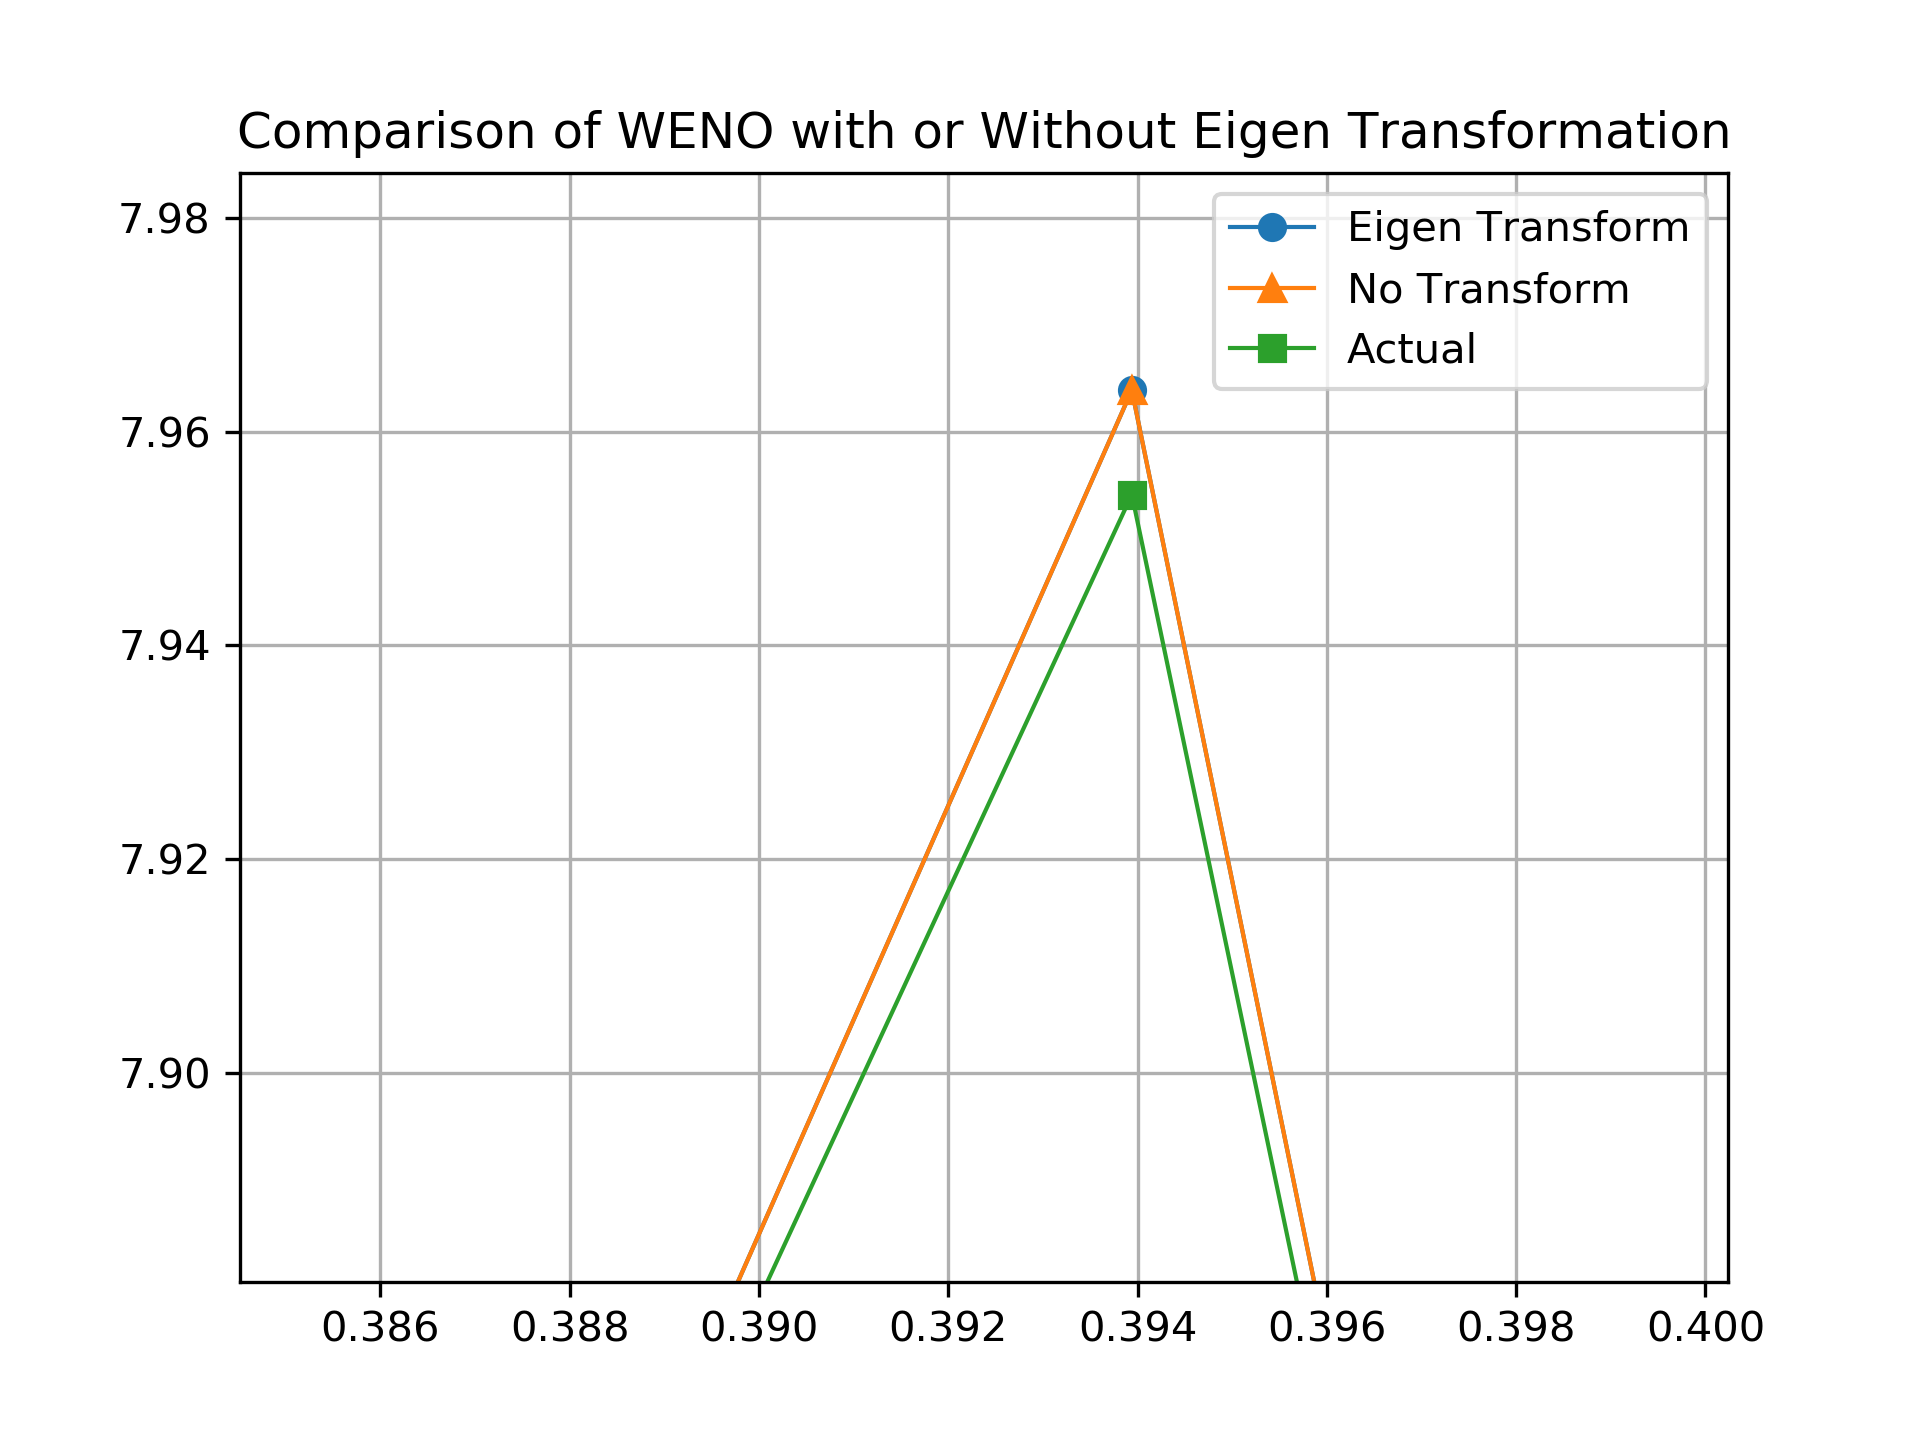

In [16]:
import thesis.testfunctions as func
import matplotlib.pyplot as plt
%matplotlib notebook

N=100
x=np.linspace(-1,1,N)
h=(x.max()-x.min())/N
u_smooth=np.array([func.gaussian(x)[0],func.gaussian(x)[0],func.gaussian(x)[0]]).T


plt.figure(dpi=150)
plt.plot(x,weno_interpolation(u_smooth,3)[:,0],linewidth=1,marker='o',label='Eigen Transform')
plt.plot(x,no_characteristic_weno(u_smooth,3)[:,0],linewidth=1,marker='^',label='No Transform')
plt.plot(x,func.gaussian(x+1/2*h)[0],linewidth=1,marker='s',label='Actual')
plt.legend()
plt.title('Comparison of WENO with or Without Eigen Transformation')
plt.grid()


Clearly, this is not an exhaustive validation of the method, but it does provide visual verification that the eigenspace transform WENO method yields the expected results for a smooth function.